In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
from astropy import units
from astropy.coordinates import AltAz, EarthLocation
from astropy.time import Time, TimezoneInfo
from astropy.visualization import quantity_support
from astropy.units import Quantity

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from tqdm.notebook import tqdm

from pyradiosky import SkyModel
from pyuvdata import UVBeam, UVData
from pyuvdata import utils as uvutils
import pyuvdata
from matvis import conversions, simulate_vis

In [3]:
quantity_support();

In [4]:
beam_file = Path("/Users/ruby/Astro/rlb_LWA/LWAbeam_2015.fits")
source_list = Path("/Users/ruby/Astro/mmode_maps_eastwood/ovro_lwa_sky_map_46.992MHz_nside128.skyh5")
# source_list = Path("/home/mkolopanis/simulations/catalogs/cyg_cas.skyh5")

In [5]:
uvb = UVBeam.from_file(beam_file)
if uvb.freq_interp_kind is None:
    uvb.freq_interp_kind = "linear"
if uvb.feed_array[0].lower() == "e":
    pol_mapping = {
        v: k for k, v in uvutils._x_orientation_rep_dict(uvb.x_orientation).items()
    }
    uvb.feed_array = np.array([pol_mapping[feed.lower()] for feed in uvb.feed_array])

In [6]:
uvb = uvb.interp(
    uvb.axis1_array,
    np.concatenate([[0], uvb.axis2_array]),
    new_object=True,
    az_za_grid=True,
)

In [7]:
uvd = UVData.from_file(
    "/Users/ruby/Astro/cal46_time11_conj.ms",
    read_data=False,
    use_future_array_shapes=True,
)

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 7.707953018755234 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [8]:
print(uvd.telescope_name == "OVRO_MMA")

True


In [9]:
# Correct telescope location
telescope = pyuvdata.telescopes.get_telescope("OVRO-LWA")
print(telescope.telescope_location)
print(uvd.telescope_location)
uvd.telescope_name = "OVRO-LWA"
uvd.set_telescope_params(overwrite=True, warn=True)
print(uvd.telescope_location)

[-2409247.20369628 -4477889.56236559  3839327.82827939]
[-2409316.83374267 -4477802.55448293  3839384.22255595]
[-2409247.20369628 -4477889.56236559  3839327.82827939]


telescope_location, telescope_name are not set or are being overwritten. Using known values for OVRO-LWA.


In [10]:
antpos, ants = uvd.get_ENU_antpos()
antpos = {a: pos for (a, pos) in zip(ants, antpos)}
uvdata_antpos = {int(a): tuple(pos) for (a, pos) in zip(ants, uvd.antenna_positions)}

In [11]:
beams = [uvb]
beam_ids = np.zeros(len(antpos), dtype=np.uint8)

In [12]:
model = SkyModel.from_skyh5(source_list)
model.at_frequencies(Quantity(uvd.freq_array, "Hz"))

In [13]:
uvd.freq_array

array([45554687.5    , 45578613.28125, 45602539.0625 , 45626464.84375,
       45650390.625  , 45674316.40625, 45698242.1875 , 45722167.96875,
       45746093.75   , 45770019.53125, 45793945.3125 , 45817871.09375,
       45841796.875  , 45865722.65625, 45889648.4375 , 45913574.21875,
       45937500.     , 45961425.78125, 45985351.5625 , 46009277.34375,
       46033203.125  , 46057128.90625, 46081054.6875 , 46104980.46875,
       46128906.25   , 46152832.03125, 46176757.8125 , 46200683.59375,
       46224609.375  , 46248535.15625, 46272460.9375 , 46296386.71875,
       46320312.5    , 46344238.28125, 46368164.0625 , 46392089.84375,
       46416015.625  , 46439941.40625, 46463867.1875 , 46487792.96875,
       46511718.75   , 46535644.53125, 46559570.3125 , 46583496.09375,
       46607421.875  , 46631347.65625, 46655273.4375 , 46679199.21875,
       46703125.     , 46727050.78125, 46750976.5625 , 46774902.34375,
       46798828.125  , 46822753.90625, 46846679.6875 , 46870605.46875,
      

data_files = sorted(
    map(str, Path("/data10/rbyrne/20230523/").glob("20230523_104458_*MHz.ms"))
)
data_files[6:]

uvd = UVData.from_file(data_files[6], read_data=False, use_future_array_shapes=True)
uvd._uvw_array.tols = (0, 0.0015)
for cnt in range(7, len(data_files)):
    uvd2 = UVData.from_file(
        data_files[cnt], read_data=False, use_future_array_shapes=True
    )
    uvd.fast_concat(uvd2, axis="freq", inplace=True)

In [14]:
"""
uvd = uvd.select(
    frequencies=uvd.freq_array[
        np.logical_and(
            np.logical_and(
                uvd.freq_array >= uvb.freq_array.min(),
                uvd.freq_array <= uvb.freq_array.max(),
            ),
            # specify the freqs here (18,41) MHz low band (41-87) high band
            np.logical_and(
                np.logical_and(
                    uvd.freq_array >= 40e6,
                    uvd.freq_array <= 88e6,
                ),
                np.logical_and(
                    uvd.freq_array >= model.freq_array.min().to_value("Hz"),
                    uvd.freq_array <= model.freq_array.max().to_value("Hz"),
                ),
            ),
        )
    ],
    inplace=False,
)
"""

'\nuvd = uvd.select(\n    frequencies=uvd.freq_array[\n        np.logical_and(\n            np.logical_and(\n                uvd.freq_array >= uvb.freq_array.min(),\n                uvd.freq_array <= uvb.freq_array.max(),\n            ),\n            # specify the freqs here (18,41) MHz low band (41-87) high band\n            np.logical_and(\n                np.logical_and(\n                    uvd.freq_array >= 40e6,\n                    uvd.freq_array <= 88e6,\n                ),\n                np.logical_and(\n                    uvd.freq_array >= model.freq_array.min().to_value("Hz"),\n                    uvd.freq_array <= model.freq_array.max().to_value("Hz"),\n                ),\n            ),\n        )\n    ],\n    inplace=False,\n)\n'

In [15]:
lat, lon, alt = uvd.telescope_location_lat_lon_alt_degrees
location = EarthLocation.from_geodetic(lat=lat, lon=lon, height=alt)

In [16]:
#obstime = Time("2023-09-07T10:59:21Z", format="isot", scale="utc", location=location)
# obstime = Time("2023-09-07T08:59:21Z", format="isot", scale="utc", location=location)
obstime = Time(np.mean(uvd.time_array), format="jd", scale="utc", location=location)
tz = TimezoneInfo(utc_offset=-7 * units.hour, dst=1 * units.hour)
lst = obstime.sidereal_time("apparent")

In [17]:
localtime = obstime.to_datetime(tz)
localtime.isoformat()

'2023-12-21T21:01:10.356314-07:00'

In [18]:
model.update_positions(obstime, location)

In [19]:
obstime.sidereal_time("apparent").deg

32.47112674328893

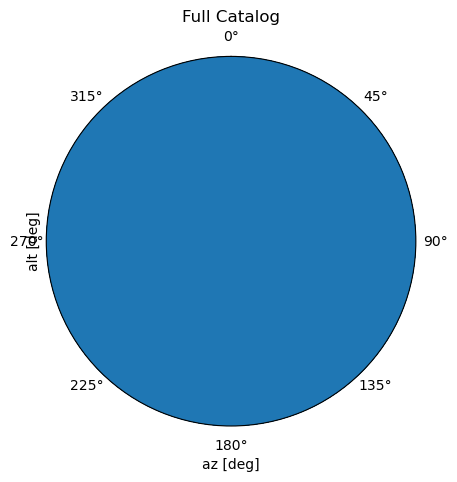

In [20]:
fig, ax = plt.subplots(1, subplot_kw={"projection": "polar"})
ax.plot(
    model.alt_az[1, model.above_horizon],
    # plot 90 - altitude becase 0 should be zenith but default matpltolib will but horizon at 0
    # since 0 altitude is the horizon
    np.pi / 2 - model.alt_az[0, model.above_horizon],
    "C0.",
)
ax.set_xlabel("az [deg]")
ax.set_ylabel("alt [deg]")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)  # clockwise
ax.grid(True)
ax.set_title("Full Catalog")
# ax.set_ylabel('Time', color='crimson')
ax.tick_params(axis="y", colors="crimson")
ax.set_ylim([0, np.pi / 2]);

In [21]:
model.cut_nonrising(telescope_latitude=location.lat, inplace=True)
# model.select(max_brightness=1000 * units.Jy, inplace=True)

In [22]:
model.healpix_to_point()

In [23]:
model.at_frequencies(uvd.freq_array * units.Hz, inplace=True)

In [24]:
empty_sources = np.nonzero(np.all(np.isclose(model.stokes[0], 0 ), axis=0))[0]
neg_sources = np.nonzero(np.all(model.stokes[0] <0 , axis=0))[0]

In [25]:
sources_to_keep  = np.setdiff1d(np.arange(model.Ncomponents), empty_sources)

In [26]:
model.select(component_inds=sources_to_keep,inplace=True)

In [27]:
stokes_factor = np.abs(model.stokes[0].min()) + 0.01 * units.Jy

In [28]:
stokes_factor, model.stokes[0].min()

(<Quantity 30.65482592 Jy>, <Quantity -30.64482592 Jy>)

In [29]:
# move the minimum to be positive flux, so we can not get NaNs in a sqrt
model.stokes += stokes_factor

In [30]:
 model.stokes[0].min()

<Quantity 0.01 Jy>

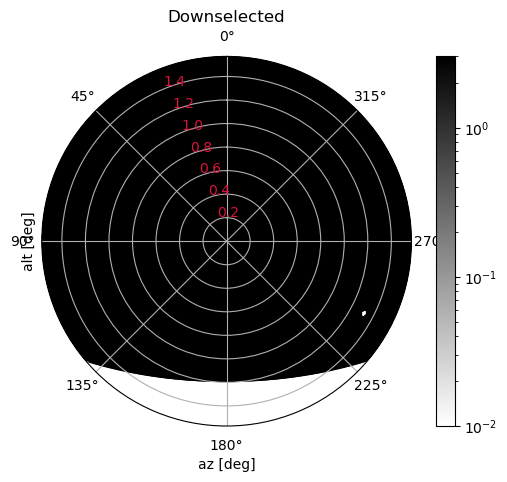

In [31]:
fig, ax = plt.subplots(1, subplot_kw={"projection": "polar"})
im = ax.scatter(
    model.alt_az[1, model.above_horizon],
    # plot 90 - altitude becase 0 should be zenith but default matpltolib will but horizon at 0
    # since 0 altitude is the horizon
    np.pi / 2 - model.alt_az[0, model.above_horizon],
    c=model.stokes[0, 0, model.above_horizon],
    marker='^',
    s=5,
    cmap="gray_r",
    norm=LogNorm(vmin=0.01, vmax=3),
);
fig.colorbar(im);
ax.set_xlabel("az [deg]")
ax.set_ylabel("alt [deg]")
ax.set_theta_zero_location("N")
# ax.set_theta_direction(-1)  # clockwise
ax.set_theta_direction(1);  # counter clockwise
ax.grid(True);
ax.set_title("Downselected");
# ax.set_ylabel('Zenith Angle', color='crimson')
ax.tick_params(axis="y", colors="crimson");
ax.set_ylim([0, np.pi / 2]);

In [ ]:
vis_full = np.zeros(
    (uvd.freq_array.size, 1, len(antpos), len(antpos)), dtype=np.complex64
)

for components in tqdm(
    np.array_split(np.arange(model.Ncomponents), 50), position=1, desc="Sources"
):
    m2 = model.select(component_inds=components, inplace=False)
    ra_new, dec_new = conversions.equatorial_to_eci_coords(
        m2.ra.rad, m2.dec.rad, obstime, location, unit="rad", frame="icrs"
    )
    assert np.all(m2.stokes[0] > 0), "Found sources with negative flux"
           
    for freq_inds in tqdm(
        np.array_split(np.arange(uvd.freq_array.size), 5),
        position=0,
        desc="Freqs",
        leave=False,
    ):
        freqs = uvd.freq_array[freq_inds]

        m3 = m2.at_frequencies(freqs * units.Hz, inplace=False)
        m3.stokes[0] = stokes_factor
        
        vis_full[freq_inds] += simulate_vis(
            ants=antpos,
            fluxes=m3.stokes[0].T.to_value("Jy"),
            ra=ra_new,
            dec=dec_new,
            freqs=freqs,
            lsts=np.array([lst.to_value("rad")]),
            beams=beams,
            beam_idx=beam_ids,
            polarized=False,
            precision=2,
            latitude=location.lat.rad,
            use_gpu=False,
        )

Sources:   0%|          | 0/50 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

Freqs:   0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
np.all(np.isnan(vis_full))

False

In [33]:
uvd._data_array.description

'Array of the visibility data, shape: (Nblts, 1, Nfreqs, Npols) or (Nblts, Nfreqs, Npols) if future_array_shapes=True, type = complex float, in units of self.vis_units.'

In [34]:
antpairs = np.array([(a1, a2) for a1 in antpos.keys() for a2 in antpos.keys()])

In [35]:
vis_full.reshape((uvd.Nfreqs, 1, len(antpos) * len(antpos))).transpose([2,1,0]).shape

(123904, 1, 192)

In [36]:
uvd_out = UVData.new(
    freq_array=uvd.freq_array,
    # really it is I but this makes casa easier
    polarization_array=["xx"],
    antenna_positions=uvdata_antpos,
    telescope_location=location,
    telescope_name="OVRO-LWA",
    times=np.array([obstime.jd]),
    antpairs=antpairs,
    data_array=vis_full.reshape((uvd.Nfreqs, 1, len(antpos) * len(antpos))).transpose([2,0,1])
)
uvd_out.telescope_location = np.array(uvd_out.telescope_location)

integration_time not provided, and cannot be inferred from time_array, setting to 1 second


In [37]:
!ls /home/mkolopanis/ovro

ls: /home/mkolopanis/ovro: No such file or directory


In [38]:
uvd_out.write_uvh5(
    "/home/mkolopanis/ovro/mmode_flux_offset.uvh5",
    fix_autos=True,
    clobber=True,
)

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = '/home/mkolopanis/ovro/mmode_flux_offset.uvh5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [ ]:
UVData.from_file("/home/mkolopanis/simulations/mmode_one_time_high_band.uvh5").write_ms(
    "/home/mkolopanis/simulations/mmode_one_time_high_band.ms",
    clobber=True,
    force_phase=True,
)

In [ ]:
!!OPENBLAS_NUM_THREADS=1 /opt/bin/wsclean -multiscale -multiscale-scale-bias 0.8 -pol XX -size 4096 4096 -scale 0.03125 -niter 0  -mgain 0.85 -weight briggs 0 -name mmode_one_time_high_band mmode_one_time_high_band.ms/

In [ ]:
!ls -lthra